In [2]:
!scala -version

Scala code runner version 2.12.14 -- Copyright 2002-2021, LAMP/EPFL and Lightbend, Inc.


In [2]:
# запуск на Dataproc Cluster

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName('gcp_lab01') \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
df = sqlContext.read.parquet('gs://advde-bucket-1/lab1/output-00000-of-00001.parquet').select("limit_balance", "age")

print(df.printSchema())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- limit_balance: double (nullable = true)
 |-- age: double (nullable = true)

None


<AxesSubplot:>

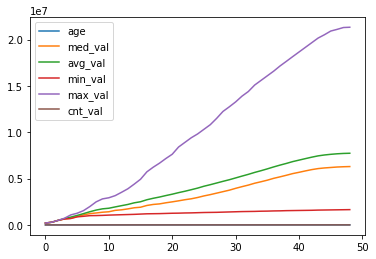

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql import Window
import pyspark.sql.functions as F

plt.close("all")

magic_percentile = F.expr('percentile_approx(limit_balance, 0.5)')

# это создание отчета зависимости в относительный величинах
pp = df.groupBy('age').agg(magic_percentile.alias('med_val') \
                      ,F.avg('limit_balance').alias('avg_val') \
                      ,F.min('limit_balance').alias('min_val') \
                      ,F.max('limit_balance').alias('max_val') \
                      ,F.count('limit_balance').alias('cnt_val') \
                     ).orderBy(F.desc("age")) \
    .toPandas().cumsum()
pp.plot()
    # это выгрузка в CSV
    #.toPandas().to_csv('gs://advde-bucket-1/lab1/cc_default_stats4.csv')


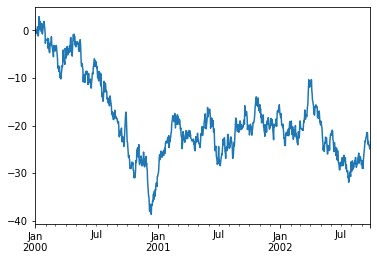

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.close("all")

ts = pd.Series(np.random.randn(1000), index=pd.date_range("1/1/2000", periods=1000))

ts = ts.cumsum()

ts.plot();

In [15]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.master("local").config(conf=SparkConf()).getOrCreate()

df = spark.createDataFrame([
    ['A', 1],
    ['A', 2],
    ['A', 3],
    ['B', 4],
    ['B', 5],
    ['B', 6]
], ['grp', 'val'])
df.printSchema()
# df.show()

magic_percentile = F.expr('percentile_approx(val, 0.5)')

#df_grp = df.groupBy('grp').agg(magic_percentile('val', 0.5).alias('med_val'))
df_grp = df.groupBy('grp') \
    .agg(
        F.sum("val").alias('sm') \
    ) \
    .show(truncate=False)

root
 |-- grp: string (nullable = true)
 |-- val: long (nullable = true)



+---+---+
|grp|sm |
+---+---+
|B  |15 |
|A  |6  |
+---+---+

